In [1]:
import cv2
from pytesseract import image_to_data, Output
import matplotlib.pyplot as plt 
from more_itertools import windowed, flatten
from itertools import groupby, chain
from PIL import ImageDraw, Image, ImageFont
import numpy as np
from copy import deepcopy
import os
from base64 import b64encode, b64decode
from pathlib import Path
import json
import networkx as nx
import shapely
from shapely.geometry import box as shapely_box

In [2]:
INPUT_DATA = "../input_data/Clarín 1985-05-22 Nueva misa de FAMUS.tif"
OUTPUT_DATA = "../out_data/"

In [3]:
image = cv2.imread(INPUT_DATA)

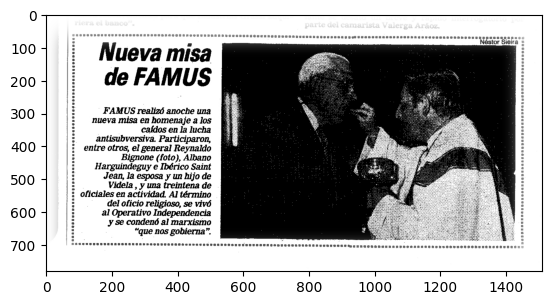

In [4]:
plt.imshow(image)

In [5]:
height, width, channels = cv2.imread(INPUT_DATA).shape

In [6]:
data_item = {
    "file_path": INPUT_DATA,
    "image": cv2.imread(INPUT_DATA),
    "image_shape": {
        "image_height" : cv2.imread(INPUT_DATA).shape[0],
        "image_width" : cv2.imread(INPUT_DATA).shape[1]
            }
}

In [7]:
data_item["image_shape"]

{'image_height': 781, 'image_width': 1511}

In [8]:
tess_configs = {
    "default": "--psm 11",
    "psm3": "--psm 3",
    "psm4": "--psm 4",
    "psm5": "--psm 5",
    "psm6": "--psm 6",
    "psm12": "--psm 12",
}

TESSERACT_LANG = "spa"
TESSERACT_CONFIG = "default"

In [9]:
def get_token_boxes(image, tesseract_langs: str, tesseract_config: str ) -> list[dict]:
    tess_config = tess_configs.get(tesseract_config, "")
    data = image_to_data(
        image,
        lang=tesseract_langs,
        config=tess_config,
        output_type=Output.DICT,
    )

    data = zip(
        data["text"],
        data["conf"],
        data["left"],
        data["top"],
        data["width"],
        data["height"],
    )

    # box format =>  (x_left, y_top, x_right, y_bottom)
    token_boxes = map(
        lambda x: {
            "text": x[0],
            "confidence": float(x[1]) / 100,
            "top": x[3],
            "left": x[2],
            "box": (x[2], x[3], x[2] + x[4], x[3] + x[5]),
            "box_area": x[4] * x[5],
            "box_height": x[5],
            "x_position": x[2],
            "y_position": x[3],
        },
        data,
    )

    token_boxes = [token for token in token_boxes if token["text"]]

    return token_boxes


MIN_NEW_LINE_OVERLAP = 0.5

def set_line_number(token_boxes: list[dict]) -> list[dict]:
    token_boxes = sorted(
        token_boxes, key=lambda x: ((x["box"][3] + x["box"][1]) / 2)
    )

    token_box_pairs = windowed(token_boxes, 2)
    line = 1
    token_boxes[0]["n_line"] = line
    for prev_token_box, token_box in token_box_pairs:
        prev_box = prev_token_box["box"]
        box = token_box["box"]
        prev_y = (prev_box[3] + prev_box[1]) / 2
        y = (box[3] + box[1]) / 2
        diff = abs(y - prev_y)
        if (box[1] > prev_box[1]) and (box[3] < prev_box[3]):
            token_box["n_line"] = line
            continue

        height = token_box["box_height"]
        if diff >= height * MIN_NEW_LINE_OVERLAP:
            line += 1

        token_box["n_line"] = line

    return token_boxes


def get_line_groups(token_boxes: list[dict]):
    line_groups = groupby(token_boxes, key=lambda x: x["n_line"])
    line_groups = map(
        lambda x: sorted(x[1], key=lambda x: x["box"][0]), line_groups
    )

    return line_groups


def set_token_box_ids(
    token_boxes: list[dict[str]],
    image_id: str,
) -> list[dict[str]]:

    line_groups = get_line_groups(token_boxes)
    sorted_token_boxes = flatten(line_groups)
    token_boxes_ = []
    for idx, token_box in enumerate(sorted_token_boxes, start=1):
        token_id = f"{image_id}-{idx}"
        token_id = b64_encoder(token_id)
        token_box_ = {"id": token_id, **token_box, "n_token": idx}
        token_boxes_.append(token_box_)

    return token_boxes_


def b64_encoder(x: str) -> str:
    encoded = b64encode(x.encode()).decode()
    return encoded


def save_json(json_data, file_path: str):
    with open(file_path, "w") as f:
        f.write(json.dumps(json_data, indent=4, ensure_ascii=False))
        

def cv2pil(cv_image: np.ndarray) -> Image:
    image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)
    return pil_image


def apply_tesseract(
    data_item,
    tesseract_langs: str = "spa",
    tesseract_config: str = "default",
    output_path: str = "",
):

    data_item = deepcopy(data_item)
    image_path = data_item["file_path"]
    img = data_item["image"]
    image = cv2pil(img)

    image_path = data_item["file_path"]
    filename = os.path.basename(image_path)
    image_id = f"{filename}"

    token_boxes = get_token_boxes(image, tesseract_langs, tesseract_config)
    token_boxes = set_line_number(token_boxes)
    token_boxes = set_token_box_ids(
        token_boxes,
        image_id,
    )

    if not token_boxes:
        logger.warning(f"WARNING no boxes for image => {image_path}")
        return

    data_item["token_boxes"] = token_boxes

    if output_path:
        path = Path(output_path)
        path.mkdir(parents=True, exist_ok=True)
        file_hash = b64_encoder(data_item["file_path"])
        save_json(token_boxes, f"{output_path}/{file_hash}.json")

    return data_item

In [10]:
data_item = apply_tesseract(data_item, output_path=OUTPUT_DATA)

In [11]:
data_item.keys()

dict_keys(['file_path', 'image', 'image_shape', 'token_boxes'])

In [12]:
data_item['token_boxes'][0].keys()

dict_keys(['id', 'text', 'confidence', 'top', 'left', 'box', 'box_area', 'box_height', 'x_position', 'y_position', 'n_line', 'n_token'])

### Debug

In [13]:
FONT = ImageFont.truetype(
    "/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 10
)


def get_boxes_line(box_1, box_2):
    #  box => (x1, y1, x2, y2)
    x1 = (box_1[0] + box_1[2]) / 2
    y1 = (box_1[1] + box_1[3]) / 2

    x2 = (box_2[0] + box_2[2]) / 2
    y2 = (box_2[1] + box_2[3]) / 2

    line = (x1, y1, x2, y2)
    return line


def doc_graph_debug(
    data_item, main_path):

    filename = os.path.basename(data_item["file_path"])

    out_path = f"{main_path}"
    out_file_path = f"{out_path}/{filename}"

    if not os.path.exists(out_path):
        Path(out_path).mkdir(parents=True)

    image = cv2pil(data_item["image"])
    token_boxes = data_item["token_boxes"]

    boxes_map = {
        token_box["id"]: token_box["box"] for token_box in token_boxes
    }

    draw = ImageDraw.Draw(image)
    for token_box in token_boxes:
        box = token_box["box"]
        n_line = token_box["n_line"]

        color = "red"
        draw.rectangle(box, outline=color, width=1)
        draw.text(
            (box[0], box[1]),
            f"{n_line}",
            font=FONT,
            anchor="rd",
            align="left",
            fill=color,
        )

    for src, tgt, attr in data_item["doc_graph"].edges(data=True):
        src_box = boxes_map[src]
        tgt_box = boxes_map[tgt]

        boxes_line = get_boxes_line(src_box, tgt_box)
        draw.line(boxes_line, fill="green", width=1)
        x, y = get_line_center(boxes_line)
        draw.text(
            (x, y),
            str(round(attr["weight"], 3)),
            font=FONT,
            anchor="rd",
            align="left",
            fill="blue",
        )
    plt.imshow(image)
    print(out_file_path)
    image.save(out_file_path)

In [14]:
# doc_graph_debug(data_item, "test")

In [15]:
V_REL_WINDOW = 5
MAX_V_WEIGHT = 0.25

def get_boxes_ditance(box_1, box_2) -> float:
    box_1 = shapely_box(*box_1)
    box_2 = shapely_box(*box_2)
    ditance = box_1.distance(box_2)
    return ditance

def get_line_center(line):
    x = int(line[2] - (line[2] - line[0]) / 2)
    y = int(line[3] - (line[3] - line[1]) / 2)
    return x, y


def get_v_rels(token_boxes: list[dict], image_height: int):
    line_groups = get_line_groups(token_boxes)
    line_groups = list(line_groups)

    for idx, line_group in enumerate(line_groups):
        for top_token in line_group:
            top_box = top_token["box"]

            bottom_idx_start = idx + 1
            bottom_tokens = flatten(line_groups[bottom_idx_start:])
            candidate_bottom_tokens = []
            for bottom_token in bottom_tokens:
                bottom_box = bottom_token["box"]

                top_x_range = range(top_box[0], top_box[2] + 1)
                bottom_x_range = range(bottom_box[0], bottom_box[2] + 1)

                if not set(top_x_range).intersection(set(bottom_x_range)):
                    continue

                candidate_box = {
                    "n_line": bottom_token["n_line"],
                    "bottom_token": bottom_token,
                }

                candidate_bottom_tokens.append(candidate_box)

            if not candidate_bottom_tokens:
                continue

            min_line = min(map(lambda x: x["n_line"], candidate_bottom_tokens))
            if (min_line - top_token["n_line"]) > V_REL_WINDOW:
                continue

            valid_bottom_tokens = filter(
                lambda x: x["n_line"] == min_line, candidate_bottom_tokens
            )

            valid_bottom_tokens = map(
                lambda x: x["bottom_token"], valid_bottom_tokens
            )

            for valid_bottom_token in valid_bottom_tokens:
                bottom_box = valid_bottom_token["box"]
                boxes_ditance = get_boxes_ditance(top_box, bottom_box)
                if not boxes_ditance:
                    continue
                    
                if (boxes_ditance / image_height) > MAX_V_WEIGHT:
                    continue

                rel = (
                    top_token["id"],
                    valid_bottom_token["id"],
                    boxes_ditance,
                )

                yield rel


def get_h_rels(token_boxes: list[dict]):
    line_groups = get_line_groups(token_boxes)
    for tokens in line_groups:
        for left_token, rigth_token in windowed(tokens, 2):

            if not left_token or not rigth_token:
                continue

            left_box = left_token["box"]
            rigth_box = rigth_token["box"]
            boxes_ditance = get_boxes_ditance(left_box, rigth_box)
            if not boxes_ditance:
                continue

            rel = (left_token["id"], rigth_token["id"], boxes_ditance)
            yield rel


In [16]:
def create_doc_graphs(
    data_item,
    debug: bool = False,
    bidirectional: bool = True,
    top_k_neighbours: int = 0,
):

    data_item = deepcopy(data_item)
    image_height = data_item["image_shape"]["image_height"]
    token_boxes = data_item["token_boxes"]

    nodes = (token_box["id"] for token_box in token_boxes)
    v_rels = get_v_rels(token_boxes, image_height)
    h_rels = get_h_rels(token_boxes)
    rels = list(chain(v_rels, h_rels))

    min_weight = min(weight for *_, weight in rels)
    rels = ((src, tgt, min_weight / weight) for src, tgt, weight in rels)

    doc_graph = nx.DiGraph()
    doc_graph.add_nodes_from(nodes)
    doc_graph.add_weighted_edges_from(rels)

    if bidirectional:
        doc_graph = nx.compose(doc_graph, doc_graph.reverse())

    if top_k_neighbours:
        doc_graph = prune_graph(doc_graph, bidirectional, top_k_neighbours)

    data_item["doc_graph"] = doc_graph

    if debug:
        doc_graph_debug(data_item, OUTPUT_DATA)

    return data_item

../out_data//Clarín 1985-05-22 Nueva misa de FAMUS.tif


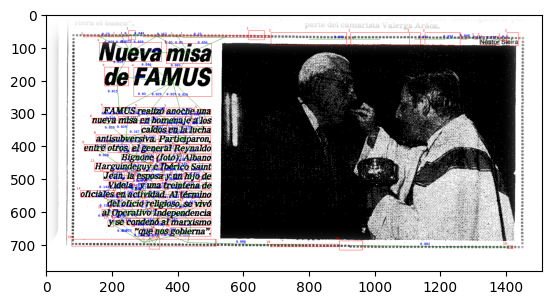

In [17]:
data_item = create_doc_graphs(data_item, debug = True)

In [18]:
data_item.keys()

dict_keys(['file_path', 'image', 'image_shape', 'token_boxes', 'doc_graph'])

In [19]:
data_item['doc_graph']